# Platform Positioning

In [1]:
from __future__ import print_function

In [70]:
import random as random #For random initial platform position
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import geopandas as gpd
from shapely.geometry.polygon import Polygon

import pickle # For importing pickled objects
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from shapely.geometry import Point, LineString #For Platform and 
from mpl_toolkits.basemap import Basemap # Mapping visualisation


# Data Ingestion

##  Target Geometry Data
This has been queried and pickled. The column names refer to the SQL function performed on geometry.
e.g. geom.AsTextZM() AS geom_text_zm

In [71]:
with open('data/0_raw/TEST_TRIN_20191111', 'rb') as f:
    df_target = pickle.load(f)
    
df_target.head()    

,target_id,target_name,geom_text_zm,geom_binary_zm,geom_STAs_binary,geom_STAs_Text
0,768,Kapok-TQ65-SPA,MULTILINESTRING ((-60.498999227043505 9.855164...,b'\x01\xed\x03\x00\x00\x01\x00\x00\x00\x01\xea...,b'\x01\x05\x00\x00\x00\x01\x00\x00\x00\x01\x02...,MULTILINESTRING ((-60.498999227043505 9.855164...
1,769,Kapok-TQ40-SPA,MULTILINESTRING ((-60.5041507381779 9.90958420...,"b""\x01\xed\x03\x00\x00\x01\x00\x00\x00\x01\xea...","b""\x01\x05\x00\x00\x00\x01\x00\x00\x00\x01\x02...",MULTILINESTRING ((-60.5041507381779 9.90958420...
2,770,Kapok-TQ30-SPA,None,None,None,None
3,771,Kapok-TQ20b-SPA,MULTILINESTRING ((-60.5024436026266 9.91144177...,b'\x01\xed\x03\x00\x00\x01\x00\x00\x00\x01\xea...,b'\x01\x05\x00\x00\x00\x01\x00\x00\x00\x01\x02...,MULTILINESTRING ((-60.5024436026266 9.91144177...
4,772,Kapok-TQ20d-SPA,None,None,None,None


Drop rows which don't have geometry

In [72]:
df_target_wgeom = df_target[df_target['geom_STAs_binary'].notnull()]
df_target_wgeom.head()

,target_id,target_name,geom_text_zm,geom_binary_zm,geom_STAs_binary,geom_STAs_Text
0,768,Kapok-TQ65-SPA,MULTILINESTRING ((-60.498999227043505 9.855164...,b'\x01\xed\x03\x00\x00\x01\x00\x00\x00\x01\xea...,b'\x01\x05\x00\x00\x00\x01\x00\x00\x00\x01\x02...,MULTILINESTRING ((-60.498999227043505 9.855164...
1,769,Kapok-TQ40-SPA,MULTILINESTRING ((-60.5041507381779 9.90958420...,"b""\x01\xed\x03\x00\x00\x01\x00\x00\x00\x01\xea...","b""\x01\x05\x00\x00\x00\x01\x00\x00\x00\x01\x02...",MULTILINESTRING ((-60.5041507381779 9.90958420...
3,771,Kapok-TQ20b-SPA,MULTILINESTRING ((-60.5024436026266 9.91144177...,b'\x01\xed\x03\x00\x00\x01\x00\x00\x00\x01\xea...,b'\x01\x05\x00\x00\x00\x01\x00\x00\x00\x01\x02...,MULTILINESTRING ((-60.5024436026266 9.91144177...
7,775,Kapok-TP95L-SPA,MULTILINESTRING ((-60.481304509800545 9.864397...,b'\x01\xed\x03\x00\x00\x01\x00\x00\x00\x01\xea...,b'\x01\x05\x00\x00\x00\x01\x00\x00\x00\x01\x02...,MULTILINESTRING ((-60.481304509800545 9.864397...
8,776,Kapok-TP95-REN,MULTILINESTRING ((-60.479890700013996 9.899954...,b'\x01\xed\x03\x00\x00\x01\x00\x00\x00\x01\xea...,b'\x01\x05\x00\x00\x00\x01\x00\x00\x00\x01\x02...,MULTILINESTRING ((-60.479890700013996 9.899954...


## Well Concept Data
As no suitable test data exists, dummy data is generated. There is a separate dummdatacreator.py file containing this work

In [73]:
from dummydatacreator import  GenerateWellConcept # This is not supported in Azure notebooks

In [74]:
def UpdateWellConceptData(n_concepts = 30, lon_min = -60.34, lon_max = -60.32, \
                          lat_min = 10.04, lat_max = 10.08):
    
    WellConcepts = [GenerateWellConcept(lon_min, lon_max, lat_min, lat_max) \
                    for i in range(n_concepts)]

    return list(zip(*WellConcepts))

WC_name, WC_points, WC_resource = UpdateWellConceptData()

print('\n'.join('Name: {}, Points: {}, Resource: {}'.format(WC_name[k], WC_points[k], WC_resource[k]) for k in range(5)))

Name: Y-18, Points: [-60.33380762343698, 10.062287382742548], Resource: 0.4295616788541298
Name: E-10, Points: [-60.32407602414623, 10.077850377923562], Resource: 119.54302728623128
Name: Yd-15, Points: [-60.33010545565094, 10.044251071965359], Resource: 121.26919609110519
Name: C-14, Points: [-60.33480664654125, 10.062965953213663], Resource: 85.04607573384027
Name: Vb-20, Points: [-60.32931119893436, 10.066279768710775], Resource: 75.30425413635032


# Data Cleaning
## Target Polygons

In [75]:
def TransformMLStoPolygon(str_mlstring):

    '''
    Transforms a multilinestring string into a shapely Polygon. X,Y coordinate pairs are extracted from the string.
    Function is likely to fail if presented with real-data, since we have assumed input as a single multilinestring.
    
    '''
    
    #Remove string pre and post fix
    str_values = str_mlstring.replace("MULTILINESTRING ((", "").replace("))", "")

    #BUG - This line should not be necessary - extra brackets around....weirdly
    str_values = str_values.replace("(","").replace(")", "")

    
    lst_xystring = str_values.split(", ")

    lst_tuples = [tuple(map(float,x.split(" "))) for x in lst_xystring]
    return Polygon(lst_tuples)

In [76]:
#Transform geometry column into shapely polygon
df_target_wgeom['polygon'] = df_target_wgeom['geom_STAs_Text'].map(lambda x: TransformMLStoPolygon(x))

#Create geoSeries
gs_targPoly = gpd.GeoSeries(df_target_wgeom['polygon'])

/Users/Pri.balachandran@ibm.com/opt/anaconda3/envs/py36-GeographicPlotting/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


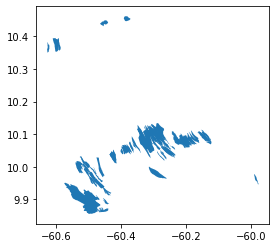

In [77]:
gs_targPoly.plot()

# Functions

In [78]:
from geopy import distance

In [79]:
def CalculateRankOfWCs(WC, plat, radii):
    '''Well Concepts are ranked according to binned distance from platform. i.e. Given input radii [0,2,5], the 
    function will return a list of rankings where:
    0 indicates Well Concept is more than 5 km from platform
    1 indictates Well Concept is between 2 and 5 km from platform... etc
    '''
    radii = np.sort(radii)
    num_radii = len(radii)

    #calculate distances of all well concepts from platform 
    distances = [distance.distance(wc_i, plat) for wc_i in WC] #Karney 2013 distance
    distances = np.reshape(distances,[-1])

    
    #Reverse ranking - where 0 is closest to platform
    revranks = np.digitize(distances, radii, right = False) #i.e. includes left bound = 0

    # Ranking - where 0 is furthest from platform
    ranking = [num_radii - revrank for revrank in revranks]
    
    return ranking

In [80]:
dct_colors = {0: "#808080",
          1:"#FF8000",
          2:"#00CC00"}


WC_points = [Point(p[0], p[1]) for p in WC_points]
WC_points = gpd.GeoSeries(WC_points)

# Mapping


## Platform Radius Functions

In [47]:
from math import tan
from math import isclose
from math import pi



def GetXYatCircumference(centre, radius, theta, tolerance = 0.00001):
    x = centre[0]
    y = centre[1]

    
    
    #If we are working in the lower two quadrants, i.e. where y will be less than centre y
    if theta > pi/2 and theta < (3*pi)/2:
        y_increment=-0.01
    else:
        y_increment=0.01

    while isclose(distance.distance(centre, [x,y]).kilometers,  radius ,rel_tol=0.00001) == False:


        #Positive Increment
        while distance.distance(centre, [x,y]) < radius:
            x_increment = y_increment * tan(theta)
            x += x_increment
            y += y_increment
            
        y_increment = y_increment/4

        while distance.distance(centre, [x,y]) > radius:
            x_increment = y_increment * tan(theta)
            x -= x_increment
            y -= y_increment

            
        y_increment = y_increment/4


    return [x,y]

GetXYatCircumference([-60.32, 10.08], 5, 0.01)

[-60.31909536169091, 10.17046081542969]

In [51]:
def GetCircumference(centre, radius, n_points, tolerance = 0.00001):
    
    #To avoid tan error
    if n_points % 2 == 0:
        n_points += 1
        
        
    theta_increment = (2*pi)/n_points

    thetas = [theta_increment * i for i in range(n_points)]
    
    xys = [GetXYatCircumference(centre, radius,theta_i,tolerance) for theta_i in  thetas]
    
    
    xys.append(xys[0])
    return xys

## Plot itself

In [82]:
from shapely.ops import transform
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection

/Users/Pri.balachandran@ibm.com/opt/anaconda3/envs/py36-GeographicPlotting/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/Pri.balachandran@ibm.com/opt/anaconda3/envs/py36-GeographicPlotting/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


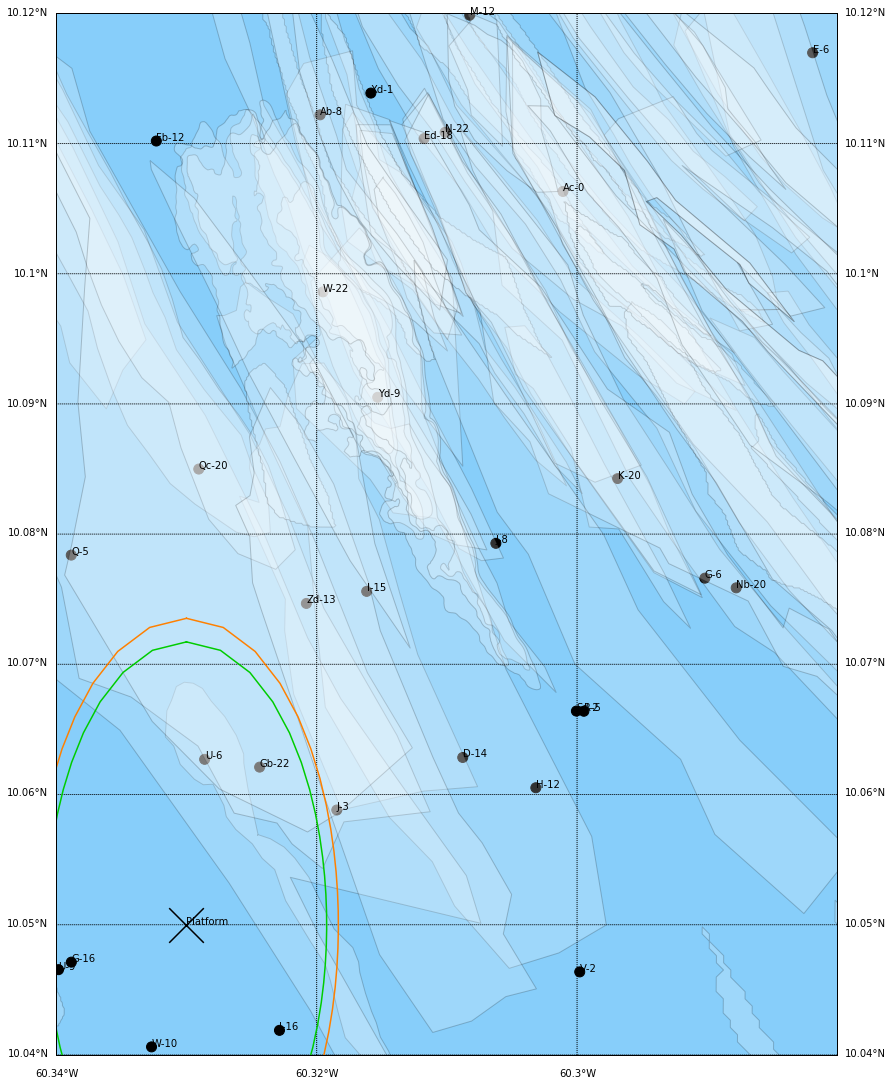

In [83]:
def plot_WC_Platform(WC_Point : Point,WC_name, WC_res: np.array,WC_col, 
                     plat_lon, plat_lat, plat_name, 
                     lon_min, lon_max, lat_min, lat_max,
                     radii,
                     figsize):


    WC_x, WC_y=list(zip(*WC_Point))

    
    water = 'lightskyblue'
    earth = 'cornsilk'

    fig, ax = plt.subplots(figsize=figsize)

    mm = Basemap(
        resolution='i',
        epsg=4326,
        llcrnrlon=lon_min,
        llcrnrlat=lat_min,

        urcrnrlon=lon_max,
        urcrnrlat=lat_max,
        lon_0=(lon_min+lon_max)/2,
        lat_0=(lat_min+lat_max)/2)
        

    bound= mm.drawmapboundary(fill_color=water)
    countries = mm.drawcountries()
    
    #i.e. x axis labels
    merid = mm.drawmeridians(
        np.arange(lon_min, lon_max, 0.02), 
        labels=[False, False, False, True])
    
    
    #y axis labels
    parall = mm.drawparallels(
        np.arange(lat_min, lat_max, 0.01), 
        labels=[True, True, False, False])
    
    
    
    #PLATFORM
    mm.scatter(plat_lon, plat_lat, marker='x', s=1200,label='plat', c="#000000")
    #Convert lat long to map xy
    platx, platy = mm(plat_lon, plat_lat)
    ax.annotate(plat_name, (platx, platy))


    
    #WC -x,y needs renaming to lon lat
    mm.scatter(WC_x, WC_y, c=WC_col, s=100)
    
    #Well concept labels
    for i, x in enumerate(WC_name):
        wcx, wcy = mm(WC_x[i], WC_y[i])

        ax.annotate(WC_name[i], ([wcx, wcy]), zorder=2)

    
    #Plot radii circumferences
    for i,r in enumerate(radii[1:],1): 
        circ_lonlat = GetCircumference([plat_lon, plat_lat],r , 51)
        circ_lon, circ_lat = list(zip(*circ_lonlat))    
        circ_x, circ_y = mm(circ_lon, circ_lat)
        ax.plot(circ_x, circ_y, dct_colors[len(radii)-i])

    
    #POLYGONS
    patches = []
    for poly in gs_targPoly:
        mmpoly = transform(mm, poly)
        patches.append(PolygonPatch(mmpoly))
        
    ax.add_collection(PatchCollection(patches,match_original=True, facecolor="#FFFFFF", alpha=0.2))
    

    
WC_name, WC_points, WC_resource = UpdateWellConceptData(30, -60.34,-60.28,10.04,10.12, )

c = ["#000000" for i in range(len(WC_name))]
plot_WC_Platform(WC_points, WC_name, WC_resource, c , -60.33,10.05,"Platform", -60.34,-60.28,10.04,10.12,[0,1.2,1.3],(14,22))    

In [105]:
def CreamMe(plat_x, plat_y, radii, figsize):

    #Subset the WCs to only those which are on the creaming curve
    WC_rank = CalculateRankOfWCs([(a[0], a[1]) for a in WC_points],(plat_x,plat_y),radii)

    #Construct dataframe of all well concepts
    df_WC = pd.DataFrame({"Well Concept": WC_name,"Resource": WC_resource, "Rank":WC_rank})
    
    #Reduce to df of well concepts on Creaming Curve (i.e. within the radii)
    df_WC_cc = df_WC[df_WC['Rank'] != 0].copy()
    
    
    df_WC_cc.loc[:,'Color'] = df_WC_cc['Rank'].map(lambda x: dct_colors[x])
    
    df_WC_cc.sort_values(by="Resource", inplace=True, ascending=False)
    
    
    

    fig, ax = plt.subplots(figsize=figsize)    

    ax.bar(df_WC_cc['Well Concept'], df_WC_cc['Resource'], color=df_WC_cc['Color'])

    ax.set_xlabel("Well Concept Name")
    ax.set_ylabel("Resource")
    plt.show()






In [106]:
def GetWCColors(WC_Points, plat_x, plat_y,radii):
    
    #Subset the WCs to only those which are on the creaming curve
    WC_rank = CalculateRankOfWCs([(a[0], a[1]) for a in WC_points],(plat_x,plat_y),radii)

    #Construct dataframe of all well concepts
    df_WC = pd.DataFrame({"Well Concept": WC_name,"Resource": WC_resource, "Rank":WC_rank})
    
   
    return df_WC['Rank'].map(lambda x: dct_colors[x])    

In [97]:
userInputs = [widgets.BoundedFloatText(
    value=round(lon_min +(random.random()*(lon_max-lon_min)), 2 ),
    min=lon_min,
    max=lon_max,
    step=0.01,
    description='X:',
    disabled=False
),
widgets.BoundedFloatText(
    value=round(lat_min +(random.random()*(lat_max-lat_min)), 2 ),
    min=lat_min,
    max=lat_max,
    step=0.01,
    description='Y:',
    disabled=False
),
  widgets.BoundedFloatText(
    value=1,
    min=0.01,
    max=1000,
    step=1,
    description='Radius (km) :',
    disabled=False)]



In [109]:
#%matplotlib inline 
from IPython.display import display

output = widgets.Output(layout={'border': '1px solid black'})


lon_min = -60.34
lon_max = -60.28
lat_min = 10.06
lat_max = 10.12
n_concepts = 30

WC_name, WC_points, WC_resource = UpdateWellConceptData(n_concepts, lon_min, lon_max, lat_min, lat_max)


def on_button_clicked(event):
    output.clear_output()

    with output:
        plat_x = userInputs[0].value
        plat_y = userInputs[1].value
        radius = userInputs[2].value
        radii = [0, radius, radius * 1.3]
        WC_colors = GetWCColors(WC_points,plat_x, plat_y, radii)
        
        plot_WC_Platform(WC_points, WC_name, WC_resource, WC_colors, plat_x,plat_y,"platform", lon_min, lon_max, lat_min, lat_max,radii,  (12,16))
        CreamMe(plat_x, plat_y, radii, (12,16))
    
        
button = widgets.Button(
    description='click me',
    layout={'width': '300px'},
    button_style='success', 
    tooltip='Run',
    icon='refresh'
)

display(widgets.Box(userInputs), button)


button.on_click(on_button_clicked)

Box(children=(BoundedFloatText(value=-60.32, description='X:', max=-60.28, min=-60.34, step=0.01), BoundedFloa…

Button(button_style='success', description='click me', icon='refresh', layout=Layout(width='300px'), style=But…

In [110]:
output

Output(layout=Layout(border='1px solid black'))

In [231]:
# FASTER ATTEMPT

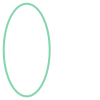

In [52]:
circ = GetCircumference([-60.32, 10.08], 1, 103, 0.00001)
LineString(circ)